## Imports

In [174]:
# Basics
import sys
import os
import itertools as it
import pandas as pd
import numpy as np

# Plotting
# import seaborn as sns
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import palettable

# Statistics
from scipy.stats import fisher_exact, linregress, ttest_rel, mannwhitneyu, ttest_ind, pearsonr

# Code
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
%matplotlib inline
pd.set_option('display.width', 2000)

## Functions

In [175]:
def stars(p):
    if p < 0.0001:
        return "****"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "-"


def plot_rank_change(axes, ranking, ctrl_str, swing_str):
    nl = ranking[ranking["Lag"] == 0]
    l = ranking[ranking["Lag"] != 0]
    axes.plot(nl[ctrl_str], nl[swing_str], '.', c='0.5', alpha=0.5, label='Not Lagged')
    axes.plot(l[ctrl_str], l[swing_str], '.', c=colors1[3], label='Lagged', zorder=1)
    axes.plot([0, 90], [0, 90], color='k', lw=1, ls='-', label='No change', zorder=0)
    axes.legend(loc='best')


def plot_diff_distribution(axes, promotion, swing_str, width=0.75):
    nl = promotion[swing_str][promotion["Lag"] == 0]
    l = promotion[swing_str][promotion["Lag"] != 0]
    pos_list = [nl, l]
    bp = axes.boxplot(pos_list, positions=range(len(pos_list)), showfliers=False, widths=width)



    # for pc in vp['bodies']:
    #     pc.set_facecolor(colors1[3])
    #     pc.set_edgecolor('w')
    #     pc.set_alpha(1)

    y_max = 0
    y_min = 0
    for whisker in bp['whiskers']:
        coords = whisker._xy[:, 1]
        y_max = max(np.max(coords), y_max)
        y_min = min(np.min(coords), y_min)

    pval = mannwhitneyu(nl, l).pvalue
    # print(pval)
    s = stars(pval)
    if pval < 0.05:
        axes.annotate("", xy=(0, y_max - .01), xycoords='data', xytext=(1, y_max + .01), textcoords='data',
                      arrowprops=dict(arrowstyle="-", ec='k', connectionstyle="bar,fraction=0.04"))
        axes.text(0.5, y_max + .05, s, horizontalalignment='center', verticalalignment='center')

    for i in range(len(bp['boxes'])):
        bp['boxes'][i].set_color(colors2[i + 2])

        # we have two whiskers!
        bp['whiskers'][i * 2].set_color(colors2[i + 2])
        bp['whiskers'][i * 2 + 1].set_color(colors2[i + 2])
        bp['whiskers'][i * 2].set_linewidth(2)
        bp['whiskers'][i * 2 + 1].set_linewidth(2)

        # top and bottom fliers
        # (set allows us to set many parameters at once)
        # bp['fliers'][i].set(marker='x', markersize=3, markeredgecolor=colors2[i+2])
        bp['medians'][i].set_color('black')
        bp['medians'][i].set_linewidth(2)
        bp['medians'][i].set_solid_capstyle('butt')

    # and 4 caps to remove
    for c in bp['caps']:
        c.set_linewidth(0)
    for i in range(len(bp['boxes'])):
        box = bp['boxes'][i]
        box.set_linewidth(0)
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        boxCoords = np.array([boxX, boxY]).T
        boxPolygon = Polygon(boxCoords, facecolor=colors2[i + 2], linewidth=0)
        axes.add_patch(boxPolygon)

    for p, val in enumerate(pos_list):
        axes.plot([p - 0.5*width/2, p + 0.5*width/2], [np.median(val), np.median(val)], c='k')
    axes.get_xaxis().tick_bottom()
    axes.get_yaxis().tick_left()
    axes.tick_params(axis='x', direction='out')
    axes.tick_params(axis='y', length=0)
    axes.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
    axes.set_axisbelow(True)
    axes.set_xticks(list(range(len(pos_list))))
    axes.set_xticklabels(['Control', 'SWING'])
    axes.set_ylim([y_min*1.2, y_max*1.2])
    
def read_tdr_results(folder_list):
    agg_df = pd.DataFrame()
    for input_folder in folder_list:
        for file_path in os.listdir(input_folder):
            if ".tsv" in file_path:
                df = pd.read_csv(input_folder + file_path, sep=',|\t', engine='python')

            # Correct weird inputs:
            # Omranian data has a messed up header
            if 'omranian' in file_path:
                new_cols = df.columns[1:]
                # Delete last column
                del df[df.columns[-1]]
                df.columns = new_cols

            agg_df = agg_df.append(df)
    return agg_df

In [176]:
def parse_tdr_results(agg_df, network_by='file_path', subgroup_by='td_window', base=21, swing=15):
    g = agg_df.groupby(by=network_by)
    net_stats = []
    for name, group in g:
        # Quick and dirty parsing
        if 'Yeast' in name or 'Ecoli' in name:
            net_name = os.path.basename(name).split('_')[0]
        else:
            net_name = os.path.basename(name).split('_t')[0]
        system = net_name.split('100')[0].split('_')[0]
        subgroup = group.groupby(by=subgroup_by)
        sg_mean = subgroup.mean()
        sg_std = subgroup.std()
        try:
            current_stats = [net_name, system, sg_mean.loc[base, 'aupr'], sg_std.loc[base, 'aupr'],
                             sg_mean.loc[swing, 'aupr'], sg_std.loc[swing, 'aupr'],
                             sg_mean.loc[base, 'auroc'], sg_std.loc[base, 'auroc'],
                             sg_mean.loc[swing, 'auroc'], sg_std.loc[swing, 'auroc']]
            net_stats.append(current_stats)
        except:
            pass

    net_stats = pd.DataFrame(net_stats, columns=['network', 'system', 'base_aupr_mean', 'base_aupr_std', 'swing_aupr_mean',
                                                 'swing_aupr_std', 'base_auroc_mean', 'base_auroc_std', 'swing_auroc_mean',
                                                 'swing_auroc_std'])
    net_stats['diff_aupr_mean'] = (net_stats['swing_aupr_mean']-net_stats['base_aupr_mean'])
    net_stats['diff_auroc_mean'] = (net_stats['swing_auroc_mean']-net_stats['base_auroc_mean'])
    
    # Melt data and mold into correct form
    melted = pd.melt(net_stats, value_vars=net_stats.columns[2:].tolist(), var_name='stat', id_vars=['network', 'system'])
    meta_data = melted.stat.str.split('_', expand=True)
    meta_data.columns = ['algorithm', 'metric', 'stat']
    del melted['stat']
    full_info = pd.concat([melted, meta_data], axis=1)
    
    return full_info

In [177]:
output_path = "./"
methods = ['Dionesus', 'Lasso', 'RandomForest']

input_folder_list = ["/Users/jfinkle/Downloads/"]
test_statistic = ['aupr', 'auroc']
save_tag = "Dionesus_Yeast100_11-20"
n_trials = 100

datasets = ["Yeast100-" + str(index) + "_" for index in range(1, 21)]
# datasets = ['insilico_size10_1','insilico_size10_2','insilico_size10_3','insilico_size10_4','insilico_size10_5']

# Summarize results for each method
comparisons = {m: parse_tdr_results(read_tdr_results(['/Users/jfinkle/Downloads/' + m + '/'])) for m in methods}
comparisons = pd.concat(comparisons.values(), keys=comparisons.keys(), axis=0)

In [178]:
unstacked = comparisons.reset_index(level=0).rename(columns={'level_0': 'method'})
unstacked.method[unstacked.method=='Dionesus'] = 'PLSR'
unstacked.method[unstacked.method=='RandomForest'] = 'RF'
unstacked.head()

/Users/jfinkle/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/jfinkle/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,method,network,system,value,algorithm,metric,stat
0,Lasso,Ecoli100-10,Ecoli,0.020782,base,aupr,mean
1,Lasso,Ecoli100-11,Ecoli,0.043051,base,aupr,mean
2,Lasso,Ecoli100-12,Ecoli,0.033139,base,aupr,mean
3,Lasso,Ecoli100-13,Ecoli,0.015532,base,aupr,mean
4,Lasso,Ecoli100-14,Ecoli,0.019775,base,aupr,mean


In [179]:
u = unstacked[(unstacked.algorithm!='diff') & (unstacked.stat=='mean') & (unstacked.system != 'insilico')]
# g = sns.FacetGrid(u, col='method', row='metric')
# g = (g.map(sns.boxplot, 'system', 'value', 'algorithm', palette='Paired', width=0.2))
# g.axes[0,0].plot([0,1], [.5,.5], '.', ms=20)

In [180]:
def plot_scores(axes, control_data, test_data, subgroups, subgroup_var, y):
    xticks = []
    xticklabels = []
    y_max = 0
    y_min = 0
    for xpos, sub in enumerate(subgroups):
        sub_ctrl = control_data[control_data[subgroup_var]==sub]
        sub_test = test_data[test_data[subgroup_var]==sub]
        # Specify the x positions for plotting
        ctrl_x, test_x = xpos-0.25, xpos+0.25
        
        # Keep track of ticks and ticklabels
        xticks.append(ctrl_x)
        xticks.append(test_x)
        xticklabels.append(sub)
        xticklabels.append(('SWING\n'+sub))
        
        x_array = np.array([[ctrl_x]*len(sub_ctrl), [test_x]*len(sub_test)])
        
        # Get y data
        y_array = [sub_ctrl[y], sub_test[y]]

        # Plot the paired points and get scaling
        axes.plot(x_array,y_array, '.-', c='0.5', mfc='0.5', alpha=0.4, zorder=1, lw=1)
        y_max = max(y_max, np.max(y_array, axis=None))
        y_min = min(y_min, np.min(y_array, axis=None))
        
        # Plot boxplot
        bp = axes.boxplot(positions=[ctrl_x, test_x], x=y_array, widths=0.25)

        # Calculate pvalue, number of stars, and annotate if significant
        pval = mannwhitneyu(control_data[y], test_data[y]).pvalue
        s = stars(pval)
        if pval < 0.05:
            
            # Annotate without text to just get a line. Anchored at control and test x positions
            axes.annotate("", xy=(ctrl_x, y_max + .005), xycoords='data', xytext=(test_x, y_max + .005), textcoords='data',
                        arrowprops=dict(arrowstyle="-", ec='k', connectionstyle="bar,fraction=0.1"), alpha=1)
            axes.text(xpos, y_max+.02, s, horizontalalignment='center', verticalalignment='center')
        
        # Adjust boxplots
        for i in range(len(bp['boxes'])):
            box_color = colors2[xpos*2+i]
            bp['boxes'][i].set_color(box_color)

            # we have two whiskers!
            bp['whiskers'][i * 2].set_color(box_color)
            bp['whiskers'][i * 2 + 1].set_color(box_color)
            bp['whiskers'][i * 2].set_linewidth(2)
            bp['whiskers'][i * 2 + 1].set_linewidth(2)

            # top and bottom fliers
            # (set allows us to set many parameters at once)
            bp['fliers'][i].set(marker='x', markersize=3,  markeredgecolor=box_color)
            bp['medians'][i].set_color('black')
            bp['medians'][i].set_linewidth(2)
            bp['medians'][i].set_solid_capstyle('butt')

        # and 4 caps to remove
        for c in bp['caps']:
            c.set_linewidth(0)
        for i in range(len(bp['boxes'])):
            box_color = colors2[xpos*2+i]
            box = bp['boxes'][i]
            box.set_linewidth(0)
            boxX = []
            boxY = []
            for j in range(5):
                boxX.append(box.get_xdata()[j])
                boxY.append(box.get_ydata()[j])
            boxCoords = np.array([boxX, boxY]).T
            boxPolygon = Polygon(boxCoords, facecolor=box_color, linewidth=0)
            axes.add_patch(boxPolygon)
        
    # Final formatting tweaks
    ax.set_xlim([-0.5, len(subgroups)-0.25])
    axes.set_xticks(xticks)
    axes.set_xticklabels(xticklabels, rotation=45, ha='center', multialignment='right') 
    axes.tick_params(axis='x', which='both', top='off', bottom='off')


    return axes

In [181]:
# Average number of edges in networks
e_path = "/Users/jfinkle/Documents/Northwestern/MoDyLS/Code/Python/Roller/data/gnw_insilico/network_data/Ecoli100/"
y_path ="/Users/jfinkle/Documents/Northwestern/MoDyLS/Code/Python/Roller/data/gnw_insilico/network_data/Yeast100/"
e_edges = []
y_edges = []
for file in os.listdir(e_path):
    if 'goldstandard.tsv' in file and "p" not in file:
        net = pd.read_csv(e_path+file, sep='\t')
        e_edges.append(sum(net['1']))
    
for file in os.listdir(y_path):
    if 'goldstandard.tsv' in file and "p" not in file:
        net = pd.read_csv(y_path+file, sep='\t')
        y_edges.append(sum(net['1']))

# Average number of true edges
e_av = np.mean(e_edges)
y_av = np.mean(y_edges)

In [182]:
colors2 = palettable.colorbrewer.get_map('Paired', 'qualitative', 10).mpl_colors
colors2 = [colors2[i] for i in [0,1,6,7,8,9]]

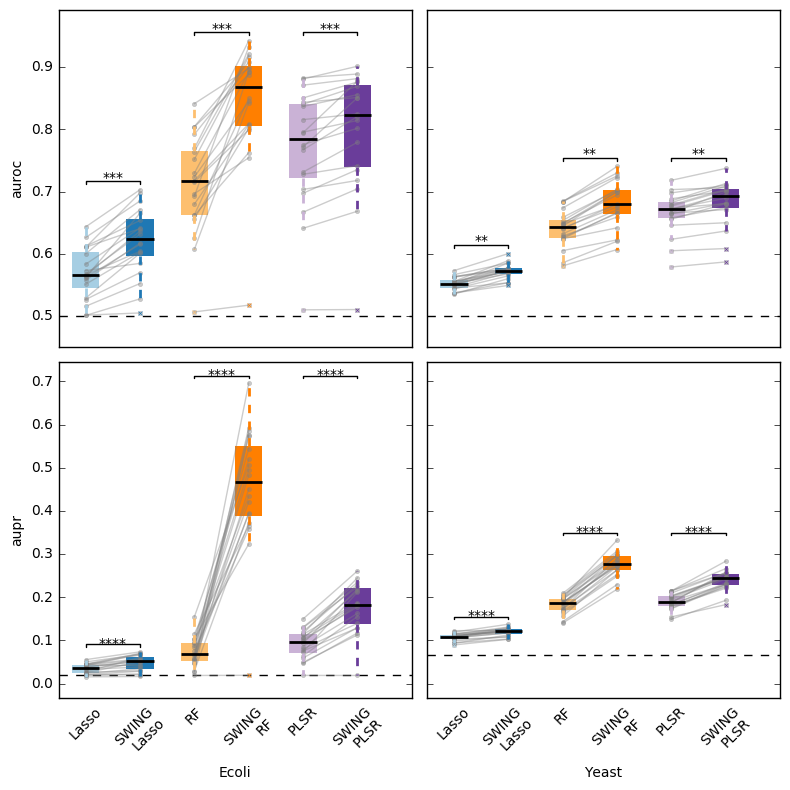

In [184]:
f = plt.figure(figsize=(8,8))
row_var = 'metric'
col_var = 'system'
pair_var = 'algorithm'
xsubgroup_var = 'method'
rows = set(u[row_var])
columns = set(u[col_var])
score_groups = u.groupby([row_var, col_var, pair_var])
xsubgroups = set(u['method'])
control = 'base'
test = 'swing'
y = 'value'
net_size = 100
limits = pd.DataFrame([[np.min(u.value[u.metric=='aupr']), np.max(u.value[u.metric=='aupr'])],
                       [np.min(u.value[u.metric=='auroc']), np.max(u.value[u.metric=='auroc'])]],
                      index=['aupr', 'auroc'], columns=['min', 'max'])
for ii, row in enumerate(rows):
    for jj, col in enumerate(columns):
        axnum = ii * len(columns) + jj + 1
        # Add subplot
        
        ax = f.add_subplot(len(rows), len(columns), axnum)
        if ii == len(rows)-1:
            ax.set_xlabel(col)
        if jj == 0:
            ax.set_ylabel(row)
        
        ctrl_data = score_groups.get_group((row, col, control))
        test_data = score_groups.get_group((row, col, test))
        ax = plot_scores(ax, ctrl_data, test_data, xsubgroups,xsubgroup_var, y)
        
        # Final formatting changes
        ax.set_ylim([limits.loc[row, 'min']-0.05, limits.loc[row, 'max']+0.05])
        
        if ii != len(rows)-1:
            ax.set_xticklabels([])
        if jj !=0:
            ax.set_yticklabels([])
        if row=='auroc':
            ax.plot(ax.get_xlim(), [0.5, 0.5], '--', c='k', zorder=0)
        if row=='aupr':
            if col == 'Ecoli':
                avg_expected_aupr = e_av/(net_size**2-net_size)
            else:
                avg_expected_aupr = y_av/(net_size**2-net_size)
            ax.plot(ax.get_xlim(), [avg_expected_aupr, avg_expected_aupr], '--', c='k', zorder=0)
        
plt.tight_layout()
plt.savefig('100node_comparison.pdf', fmt='pdf')
#         p_value = mannwhitneyu(control, test).pvalue